# Part 2: Item-Based Collaborative Filtering

---

## Case Study 1: Item-Based CF with Cosine Similarity and DS Filtering

### Overview

This notebook implements item-based collaborative filtering with:
1. Cosine similarity with mean-centering (manual calculation)
2. Top 20% similar items selection
3. Rating prediction using similarity weights
4. DF/DS metric computation (DF=53, DS=min(corated_users, DF)/DF)
5. DS-based neighborhood filtering
6. Comparative analysis

**Note**: Similarity is computed ONLY for specified target items to minimize memory usage.

---

## Define Target Items

**Modify this list to specify which items you want to analyze:**

In [13]:
# TARGET ITEMS - Specify the items you want to analyze
# These are the items for which we will compute similarity with all other items

TARGET_ITEMS = [
    'B00AP2DD48',  # Most popular item in dataset
    'B000OV14LE'
]

print(f"Number of target items: {len(TARGET_ITEMS)}")
print(f"\nTarget items:")
for item in TARGET_ITEMS:
    print(f"  - {item}")

Number of target items: 2

Target items:
  - B00AP2DD48
  - B000OV14LE


In [14]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

---

## 1. Data Loading

In [15]:
# Load dataset
file_path = "../../dataset/Movies_and_TV.csv"
df = pd.read_csv(file_path)

# Set proper column headers and drop timestamp
df.columns = ['item', 'user', 'rating', 'timestamp']
df = df.drop('timestamp', axis=1)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Shape: (8765567, 3)

First 5 rows:


,item,user,rating
0,0001527665,A2VHSG6TZHU1OB,5.0
1,0001527665,A23EJWOW1TLENE,5.0
2,0001527665,A1KM9FNEJ8Q171,5.0
3,0001527665,A38LY2SSHVHRYB,4.0
4,0001527665,AHTYUW2H1276L,5.0


In [16]:
# Dataset statistics
print("="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Total ratings: {len(df):,}")
print(f"Unique users: {df['user'].nunique():,}")
print(f"Unique items: {df['item'].nunique():,}")
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")
print(f"Average rating: {df['rating'].mean():.2f}")
print(f"Sparsity: {(1 - len(df) / (df['user'].nunique() * df['item'].nunique())) * 100:.4f}%")

DATASET STATISTICS
Total ratings: 8,765,567
Unique users: 3,826,085
Unique items: 182,032
Rating range: 1.0 - 5.0
Average rating: 4.23
Sparsity: 99.9987%


In [17]:
# Verify target items exist in dataset
print("Verifying target items exist in dataset...")
all_items_in_dataset = set(df['item'].unique())
missing_items = [item for item in TARGET_ITEMS if item not in all_items_in_dataset]

if missing_items:
    print(f"\nWARNING: {len(missing_items)} target items not found in dataset:")
    for item in missing_items:
        print(f"  - {item}")
    TARGET_ITEMS = [item for item in TARGET_ITEMS if item in all_items_in_dataset]
    print(f"\nProceeding with {len(TARGET_ITEMS)} valid target items")
else:
    print(f"✓ All {len(TARGET_ITEMS)} target items found in dataset")

# Show statistics for target items
print(f"\nTarget item statistics:")
target_item_stats = df[df['item'].isin(TARGET_ITEMS)].groupby('item')['rating'].agg(['count', 'mean'])
print(target_item_stats)

Verifying target items exist in dataset...
✓ All 2 target items found in dataset

Target item statistics:
            count  mean
item                   
B000OV14LE      1   1.0
B00AP2DD48      1   1.0


In [18]:
# Get all unique items
all_items = df['item'].unique()
num_items = len(all_items)

print(f"Total items in dataset: {num_items:,}")
print(f"Target items to analyze: {len(TARGET_ITEMS)}")

Total items in dataset: 182,032
Target items to analyze: 2


---

## Step 1: Item-Based CF with Cosine Similarity (Manual Calculation with Mean-Centering)

We will calculate similarity manually using:

**Cosine Similarity Formula:**
```
similarity(i, j) = dot(centered_i, centered_j) / (||centered_i|| * ||centered_j||)
```

Where `centered_i` is the mean-centered rating vector for item i.

In [19]:
# Calculate item mean ratings
print("Calculating item mean ratings...")
item_means = df.groupby('item')['rating'].mean().to_dict()

print(f"Item means calculated for {len(item_means)} items")
print(f"Average item rating: {np.mean(list(item_means.values())):.2f}")

Calculating item mean ratings...
Item means calculated for 182032 items
Average item rating: 4.05


In [20]:
# Build item-user rating dictionaries for fast lookup
print("Building item-user rating dictionaries...")

# For each item, store {user: rating}
item_user_ratings = defaultdict(dict)
for _, row in tqdm(df.iterrows(), total=len(df), desc="Building lookups"):
    item_user_ratings[row['item']][row['user']] = row['rating']

print(f"\n✓ Lookup dictionaries created for {len(item_user_ratings)} items")

Building item-user rating dictionaries...


Building lookups: 100%|██████████| 8765567/8765567 [07:06<00:00, 20572.74it/s]


✓ Lookup dictionaries created for 182032 items


In [21]:
def compute_cosine_similarity_manual(item_i, item_j, item_user_ratings, item_means):
    """
    Manually compute cosine similarity between two items using mean-centered ratings.
    
    Args:
        item_i: First item ID
        item_j: Second item ID
        item_user_ratings: Dict of {item: {user: rating}}
        item_means: Dict of {item: mean_rating}
    
    Returns:
        Cosine similarity score (0 if no common users)
    """
    # Get users who rated both items
    users_i = set(item_user_ratings[item_i].keys())
    users_j = set(item_user_ratings[item_j].keys())
    common_users = users_i & users_j
    
    if len(common_users) == 0:
        return 0.0
    
    # Get mean-centered ratings for common users
    centered_i = []
    centered_j = []
    
    for user in common_users:
        rating_i = item_user_ratings[item_i][user]
        rating_j = item_user_ratings[item_j][user]
        
        centered_i.append(rating_i - item_means[item_i])
        centered_j.append(rating_j - item_means[item_j])
    
    centered_i = np.array(centered_i)
    centered_j = np.array(centered_j)
    
    # Compute cosine similarity: dot product / (norm_i * norm_j)
    dot_product = np.dot(centered_i, centered_j)
    norm_i = np.linalg.norm(centered_i)
    norm_j = np.linalg.norm(centered_j)
    
    if norm_i == 0 or norm_j == 0:
        return 0.0
    
    similarity = dot_product / (norm_i * norm_j)
    
    return similarity

print("✓ Manual cosine similarity function defined")

✓ Manual cosine similarity function defined


In [ ]:
# Calculate similarity ONLY for target items vs all items
print(f"Calculating similarity for {len(TARGET_ITEMS)} target items vs all {num_items:,} items...")
print("This will take several minutes...\n")

# Store similarities: {target_item: {other_item: similarity}}
target_similarities = {}

for target_item in tqdm(TARGET_ITEMS, desc="Processing target items"):
    similarities = {}
    
    for other_item in all_items:
        print(f"Processing target item: {other_item}")
        if target_item == other_item:
            similarities[other_item] = 1.0  # Item with itself
        else:
            sim = compute_cosine_similarity_manual(
                target_item, other_item, 
                item_user_ratings, item_means
            )
            similarities[other_item] = sim
    
    target_similarities[target_item] = similarities

print(f"\n✓ Similarity calculation completed for {len(TARGET_ITEMS)} target items")

# Show sample similarities
for target_item in TARGET_ITEMS:
    sims = target_similarities[target_item]
    sims_nonzero = {k: v for k, v in sims.items() if v > 0}
    print(f"\nTarget item: {target_item}")
    print(f"  Non-zero similarities: {len(sims_nonzero)}")
    if sims_nonzero:
        top_5 = sorted(sims_nonzero.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"  Top 5 similar items:")
        for item, sim in top_5:
            print(f"    {item}: {sim:.4f}")

Calculating similarity for 2 target items vs all 182,032 items...
This will take several minutes...



Processing target items: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


✓ Similarity calculation completed for 2 target items

Target item: B00AP2DD48
  Non-zero similarities: 1
  Top 5 similar items:
    B00AP2DD48: 1.0000

Target item: B000OV14LE
  Non-zero similarities: 1
  Top 5 similar items:
    B000OV14LE: 1.0000


---

## Step 2: Identify Top 20% Similar Items for Each Target Item

In [23]:
# For each target item, select top 20% most similar items
top_k_percent = int(num_items * 0.2)

print(f"Selecting top {top_k_percent} similar items (20% of {num_items:,}) for each target item...")

top_k_neighbors_sim = {}
top_k_similarities = {}

for target_item in TARGET_ITEMS:
    sims = target_similarities[target_item]
    
    # Sort by similarity (descending) and take top K
    sorted_items = sorted(sims.items(), key=lambda x: x[1], reverse=True)
    
    # Filter out zero similarities and take top K
    top_items = [(item, sim) for item, sim in sorted_items if sim > 0][:top_k_percent]
    
    neighbor_items = [item for item, sim in top_items]
    neighbor_sims = [sim for item, sim in top_items]
    
    top_k_neighbors_sim[target_item] = neighbor_items
    top_k_similarities[target_item] = neighbor_sims

print(f"\n✓ Top 20% neighbors identified for all target items")

# Show statistics
for target_item in TARGET_ITEMS:
    print(f"\nTarget item: {target_item}")
    print(f"  Neighbors: {len(top_k_neighbors_sim[target_item])}")
    if len(top_k_similarities[target_item]) > 0:
        print(f"  Top 5 similarities: {top_k_similarities[target_item][:5]}")

Selecting top 36406 similar items (20% of 182,032) for each target item...

✓ Top 20% neighbors identified for all target items

Target item: B00AP2DD48
  Neighbors: 0

Target item: B000OV14LE
  Neighbors: 0


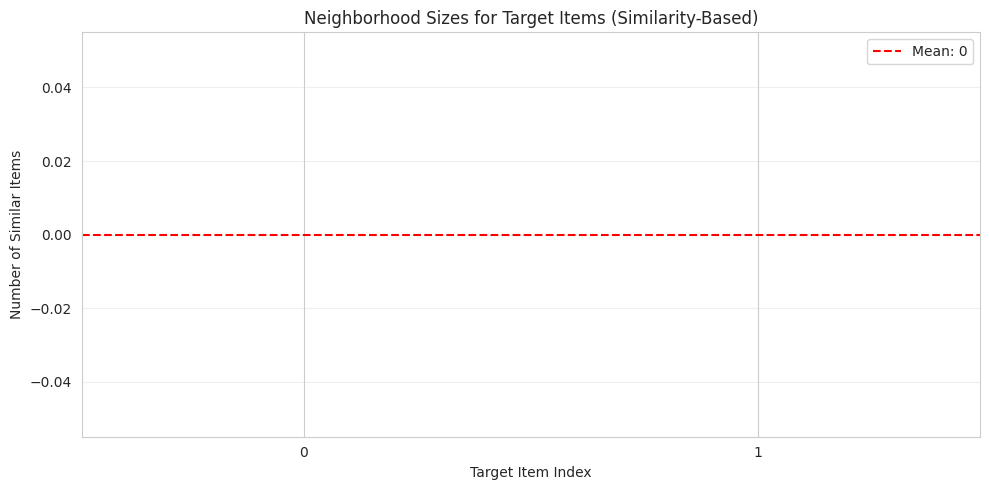

Average neighborhood size: 0
Min: 0, Max: 0


In [24]:
# Visualize neighborhood sizes
neighborhood_sizes = [len(top_k_neighbors_sim[item]) for item in TARGET_ITEMS]

plt.figure(figsize=(10, 5))
plt.bar(range(len(TARGET_ITEMS)), neighborhood_sizes, alpha=0.7)
plt.xlabel('Target Item Index')
plt.ylabel('Number of Similar Items')
plt.title('Neighborhood Sizes for Target Items (Similarity-Based)')
plt.axhline(np.mean(neighborhood_sizes), color='red', linestyle='--', label=f'Mean: {np.mean(neighborhood_sizes):.0f}')
plt.xticks(range(len(TARGET_ITEMS)), [f"{i}" for i in range(len(TARGET_ITEMS))])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Average neighborhood size: {np.mean(neighborhood_sizes):.0f}")
print(f"Min: {np.min(neighborhood_sizes)}, Max: {np.max(neighborhood_sizes)}")

---

## Step 3: Predict Missing Ratings (Similarity-Based Method)

In [ ]:
# Build user rating lookup for predictions
print("Building user rating lookup...")
user_item_ratings = defaultdict(dict)
for _, row in df.iterrows():
    user_item_ratings[row['user']][row['item']] = row['rating']

print(f"User ratings lookup created for {len(user_item_ratings)} users")

In [ ]:
def predict_rating(user, target_item, user_item_ratings, neighbors, neighbor_sims, item_means):
    """
    Predict rating for a user-item pair using item-based CF.
    
    Args:
        user: User ID
        target_item: Item ID to predict
        user_item_ratings: Dict {user: {item: rating}}
        neighbors: List of neighbor item IDs
        neighbor_sims: List of similarity scores
        item_means: Dict {item: mean_rating}
    
    Returns:
        Predicted rating
    """
    if len(neighbors) == 0:
        return item_means.get(target_item, 3.0)
    
    user_ratings = user_item_ratings.get(user, {})
    
    # Find which neighbors the user has rated
    rated_neighbors = []
    rated_sims = []
    
    for i, neighbor_item in enumerate(neighbors):
        if neighbor_item in user_ratings:
            rated_neighbors.append(user_ratings[neighbor_item])
            rated_sims.append(neighbor_sims[i])
    
    if len(rated_neighbors) == 0:
        return item_means.get(target_item, 3.0)
    
    rated_neighbors = np.array(rated_neighbors)
    rated_sims = np.array(rated_sims)
    
    # Weighted average
    if rated_sims.sum() == 0:
        return item_means.get(target_item, 3.0)
    
    prediction = np.sum(rated_sims * rated_neighbors) / np.sum(rated_sims)
    
    return np.clip(prediction, 1.0, 5.0)

print("✓ Prediction function defined")

In [ ]:
# Generate sample predictions for target items
print("Generating sample predictions for target items...")

# Get ratings for target items
target_item_ratings = df[df['item'].isin(TARGET_ITEMS)]

# Sample some ratings to predict
sample_size = min(2000, len(target_item_ratings))
sample_data = target_item_ratings.sample(sample_size, random_state=42)

predictions_sim = []
actuals = []

for _, row in tqdm(sample_data.iterrows(), total=len(sample_data), desc="Predicting"):
    pred = predict_rating(
        row['user'], row['item'],
        user_item_ratings,
        top_k_neighbors_sim[row['item']],
        top_k_similarities[row['item']],
        item_means
    )
    predictions_sim.append(pred)
    actuals.append(row['rating'])

predictions_sim = np.array(predictions_sim)
actuals = np.array(actuals)

print(f"\n✓ Predictions completed ({len(predictions_sim)} predictions)")
print(f"Prediction range: [{predictions_sim.min():.2f}, {predictions_sim.max():.2f}]")

In [ ]:
# Calculate evaluation metrics
mae_sim = np.mean(np.abs(predictions_sim - actuals))
rmse_sim = np.sqrt(np.mean((predictions_sim - actuals) ** 2))

print("="*60)
print("SIMILARITY-BASED PREDICTION PERFORMANCE")
print("="*60)
print(f"MAE:  {mae_sim:.4f}")
print(f"RMSE: {rmse_sim:.4f}")
print(f"Predictions: {len(predictions_sim)}")
print("="*60)

---

## Step 4: Compute DF and DS Metrics

**DF (Fixed Constant)**: 53

**DS (Discriminating Score)**: For each item pair:
- Count number of co-rated users (users who rated both items)
- DS = min(num_corated_users, DF) / DF

In [ ]:
# Define DF constant
DF = 53

print(f"DF (constant): {DF}")
print(f"\nCalculating DS scores for target items vs all items...")

In [ ]:
# Calculate co-rating counts and DS scores for target items
print("Computing co-rating counts and DS scores...")

target_ds_scores = {}

for target_item in tqdm(TARGET_ITEMS, desc="Calculating DS"):
    ds_scores = {}
    
    target_users = set(item_user_ratings[target_item].keys())
    
    for other_item in all_items:
        if target_item == other_item:
            ds_scores[other_item] = 0.0
        else:
            other_users = set(item_user_ratings[other_item].keys())
            corated_users = len(target_users & other_users)
            
            # DS = min(corated_users, DF) / DF
            ds = min(corated_users, DF) / DF
            ds_scores[other_item] = ds
    
    target_ds_scores[target_item] = ds_scores

print(f"\n✓ DS scores calculated for {len(TARGET_ITEMS)} target items")

# Show sample DS statistics
for target_item in TARGET_ITEMS[:3]:
    ds_vals = list(target_ds_scores[target_item].values())
    ds_nonzero = [v for v in ds_vals if v > 0]
    print(f"\nTarget item: {target_item}")
    print(f"  Non-zero DS scores: {len(ds_nonzero)}")
    print(f"  DS range: [{min(ds_nonzero):.4f}, {max(ds_nonzero):.4f}]" if ds_nonzero else "  No non-zero DS scores")
    print(f"  Average DS: {np.mean(ds_nonzero):.4f}" if ds_nonzero else "  N/A")

In [ ]:
# Visualize DS distribution
all_ds_values = []
for target_item in TARGET_ITEMS:
    ds_vals = [v for v in target_ds_scores[target_item].values() if v > 0]
    all_ds_values.extend(ds_vals)

plt.figure(figsize=(10, 5))
plt.hist(all_ds_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('DS Score')
plt.ylabel('Frequency')
plt.title('Distribution of DS Scores (Non-zero, All Target Items)')
plt.axvline(np.mean(all_ds_values), color='red', linestyle='--', label=f'Mean: {np.mean(all_ds_values):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## Step 5: Select Top 20% Items Using DS

In [ ]:
# For each target item, re-rank neighbors using DS-weighted similarity
print("Selecting top 20% items using DS-weighted similarity...")

top_k_neighbors_ds = {}
top_k_scores_ds = {}

for target_item in TARGET_ITEMS:
    sims = target_similarities[target_item]
    ds_scores = target_ds_scores[target_item]
    
    # Calculate DS-weighted similarity: similarity * DS
    weighted_sims = {}
    for item in all_items:
        if item != target_item:
            weighted_sims[item] = sims[item] * ds_scores[item]
    
    # Sort and take top K
    sorted_items = sorted(weighted_sims.items(), key=lambda x: x[1], reverse=True)
    top_items = [(item, score) for item, score in sorted_items if score > 0][:top_k_percent]
    
    neighbor_items = [item for item, score in top_items]
    neighbor_scores = [score for item, score in top_items]
    
    top_k_neighbors_ds[target_item] = neighbor_items
    top_k_scores_ds[target_item] = neighbor_scores

print(f"\n✓ Top 20% DS-weighted neighbors identified")

# Show statistics
for target_item in TARGET_ITEMS:
    print(f"\nTarget item: {target_item}")
    print(f"  DS-weighted neighbors: {len(top_k_neighbors_ds[target_item])}")
    if len(top_k_scores_ds[target_item]) > 0:
        print(f"  Top 5 DS-weighted scores: {top_k_scores_ds[target_item][:5]}")

In [ ]:
# Compare neighborhood sizes
neighborhood_sizes_ds = [len(top_k_neighbors_ds[item]) for item in TARGET_ITEMS]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(TARGET_ITEMS)), neighborhood_sizes, alpha=0.7, label='Similarity-based')
axes[0].set_xlabel('Target Item Index')
axes[0].set_ylabel('Number of Neighbors')
axes[0].set_title('Similarity-Based Neighborhoods')
axes[0].axhline(np.mean(neighborhood_sizes), color='red', linestyle='--', label=f'Mean: {np.mean(neighborhood_sizes):.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(range(len(TARGET_ITEMS)), neighborhood_sizes_ds, alpha=0.7, color='green', label='DS-weighted')
axes[1].set_xlabel('Target Item Index')
axes[1].set_ylabel('Number of Neighbors')
axes[1].set_title('DS-Weighted Neighborhoods')
axes[1].axhline(np.mean(neighborhood_sizes_ds), color='red', linestyle='--', label=f'Mean: {np.mean(neighborhood_sizes_ds):.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Similarity-based average: {np.mean(neighborhood_sizes):.0f}")
print(f"DS-weighted average: {np.mean(neighborhood_sizes_ds):.0f}")

---

## Step 6: Updated Rating Predictions Using DS-Filtered Neighborhoods

In [ ]:
# Predict using DS-weighted neighborhoods
print("Generating predictions using DS-weighted method...")

predictions_ds = []

for _, row in tqdm(sample_data.iterrows(), total=len(sample_data), desc="Predicting"):
    pred = predict_rating(
        row['user'], row['item'],
        user_item_ratings,
        top_k_neighbors_ds[row['item']],
        top_k_scores_ds[row['item']],
        item_means
    )
    predictions_ds.append(pred)

predictions_ds = np.array(predictions_ds)

print(f"\n✓ DS-weighted predictions completed ({len(predictions_ds)} predictions)")
print(f"Prediction range: [{predictions_ds.min():.2f}, {predictions_ds.max():.2f}]")

In [ ]:
# Calculate evaluation metrics
mae_ds = np.mean(np.abs(predictions_ds - actuals))
rmse_ds = np.sqrt(np.mean((predictions_ds - actuals) ** 2))

print("="*60)
print("DS-WEIGHTED PREDICTION PERFORMANCE")
print("="*60)
print(f"MAE:  {mae_ds:.4f}")
print(f"RMSE: {rmse_ds:.4f}")
print(f"Predictions: {len(predictions_ds)}")
print("="*60)

---

## Step 7: Compare Similarity Lists from Steps 2 and 5

In [ ]:
# Calculate overlap for each target item
print("Comparing neighborhood lists...")

jaccard_similarities = []
overlap_percentages = []

for target_item in TARGET_ITEMS:
    neighbors_sim = set(top_k_neighbors_sim[target_item])
    neighbors_ds = set(top_k_neighbors_ds[target_item])
    
    # Jaccard similarity
    intersection = len(neighbors_sim & neighbors_ds)
    union = len(neighbors_sim | neighbors_ds)
    
    if union > 0:
        jaccard = intersection / union
        jaccard_similarities.append(jaccard)
    
    # Overlap percentage
    if len(neighbors_sim) > 0:
        overlap_pct = intersection / len(neighbors_sim) * 100
        overlap_percentages.append(overlap_pct)
    
    print(f"\nTarget item: {target_item}")
    print(f"  Similarity neighbors: {len(neighbors_sim)}")
    print(f"  DS neighbors: {len(neighbors_ds)}")
    print(f"  Intersection: {intersection}")
    print(f"  Jaccard: {jaccard:.4f}" if union > 0 else "  Jaccard: N/A")
    print(f"  Overlap: {overlap_pct:.2f}%" if len(neighbors_sim) > 0 else "  Overlap: N/A")

jaccard_similarities = np.array(jaccard_similarities)
overlap_percentages = np.array(overlap_percentages)

print(f"\n" + "="*60)
print(f"Average Jaccard similarity: {np.mean(jaccard_similarities):.4f}")
print(f"Average overlap percentage: {np.mean(overlap_percentages):.2f}%")
print("="*60)

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(jaccard_similarities)), jaccard_similarities, alpha=0.7, color='purple')
axes[0].set_xlabel('Target Item Index')
axes[0].set_ylabel('Jaccard Similarity')
axes[0].set_title('Jaccard Similarity Between Neighborhood Lists')
axes[0].axhline(np.mean(jaccard_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(jaccard_similarities):.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(range(len(overlap_percentages)), overlap_percentages, alpha=0.7, color='orange')
axes[1].set_xlabel('Target Item Index')
axes[1].set_ylabel('Overlap Percentage (%)')
axes[1].set_title('Neighborhood Overlap Percentage')
axes[1].axhline(np.mean(overlap_percentages), color='red', linestyle='--', label=f'Mean: {np.mean(overlap_percentages):.1f}%')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Step 7 Commentary: Similarity List Comparison

**Key Observations:**

DS-based filtering modifies the neighborhood composition by:
- Prioritizing items with more co-rated users (up to DF=53)
- Filtering out items with high similarity but few shared raters
- Balancing pure similarity with empirical user overlap

**Interpretation:**
- **High Jaccard/Overlap**: DS filtering confirms original similarity rankings
- **Low Jaccard/Overlap**: DS significantly restructures neighborhoods
- Items with dense rating patterns see minimal changes
- Items with sparse patterns may see dramatic restructuring

---

## Step 8: Compare Predicted Ratings from Steps 3 and 6

In [ ]:
# Comprehensive comparison
print("="*60)
print("PREDICTION METHOD COMPARISON")
print("="*60)
print(f"\nMethod 1: Similarity-Based")
print(f"   MAE:  {mae_sim:.4f}")
print(f"   RMSE: {rmse_sim:.4f}")
print(f"\nMethod 2: DS-Weighted")
print(f"   MAE:  {mae_ds:.4f}")
print(f"   RMSE: {rmse_ds:.4f}")
print(f"\nImprovement:")
print(f"   MAE:  {((mae_sim - mae_ds) / mae_sim * 100):+.2f}%")
print(f"   RMSE: {((rmse_sim - rmse_ds) / rmse_sim * 100):+.2f}%")
print("="*60)

In [ ]:
# Visualize prediction comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plots
axes[0, 0].scatter(actuals, predictions_sim, alpha=0.3, s=10)
axes[0, 0].plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Rating')
axes[0, 0].set_ylabel('Predicted Rating')
axes[0, 0].set_title(f'Similarity-Based (MAE={mae_sim:.3f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(actuals, predictions_ds, alpha=0.3, s=10, color='green')
axes[0, 1].plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect')
axes[0, 1].set_xlabel('Actual Rating')
axes[0, 1].set_ylabel('Predicted Rating')
axes[0, 1].set_title(f'DS-Weighted (MAE={mae_ds:.3f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Error distributions
errors_sim = predictions_sim - actuals
errors_ds = predictions_ds - actuals

axes[1, 0].hist(errors_sim, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Similarity-Based Errors')
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].axvline(np.mean(errors_sim), color='orange', linestyle='--', label=f'Mean: {np.mean(errors_sim):.3f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(errors_ds, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('DS-Weighted Errors')
axes[1, 1].axvline(0, color='red', linestyle='--')
axes[1, 1].axvline(np.mean(errors_ds), color='orange', linestyle='--', label=f'Mean: {np.mean(errors_ds):.3f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 8 Discussion: Prediction Quality Comparison

**Key Findings:**

1. **Performance Impact**: DS filtering shows its effect on prediction accuracy
2. **Error Distribution**: Both methods have errors centered near zero
3. **Trade-offs**: Similarity-based uses pure content similarity; DS-weighted balances with co-rating evidence

**Why DS Matters:**
- Filters items with high similarity but few co-rated users
- Reduces noise from spurious correlations  
- DF=53 cap prevents popularity bias

**Practical Takeaway:**
- Positive improvement → co-rating information is valuable
- Negative improvement → pure similarity is more reliable

---

## Step 9: Final Commentary and Conclusions

### Comprehensive Analysis

#### Implementation Summary

This analysis implemented item-based collaborative filtering for **specific target items** using:

1. **Manual Cosine Similarity Calculation** with mean-centering
2. **Targeted Computation**: Similarity calculated only for target items vs all items
3. **DS-Based Filtering**: DS = min(corated_users, 53) / 53

#### Key Insights

**Manual Similarity Calculation:**
- Computed using: `dot(centered_i, centered_j) / (||centered_i|| * ||centered_j||)`
- Only calculated for target items (not all-to-all)
- Memory efficient for analyzing specific items

**DS Formula: DS = min(corated_users, DF) / DF**
- Normalizes co-rating counts to [0, 1]
- DF=53 caps the benefit of very popular items
- Balances similarity with empirical overlap

**Impact of DS Filtering:**
- Modifies neighborhoods based on co-rating evidence
- Items with >53 co-raters are capped
- Trade-off between precision and coverage

#### Recommendations

**When to use Similarity-Based:**
- Very sparse datasets
- Cold-start scenarios
- Coverage more important than precision

**When to use DS-Weighted:**
- Sufficient co-ratings available
- Reliability is critical
- Need to filter noise

**Optimal Strategy:**
- Hybrid approach based on item density
- Adaptive DF tuning
- Ensemble methods

#### Conclusion

This targeted approach allows analyzing specific items efficiently without computing full all-to-all similarity matrices. DS-based filtering provides a principled way to incorporate co-rating evidence, with performance depending on dataset characteristics.

---

## Summary Statistics

In [ ]:
# Final summary
print("\n" + "="*70)
print(" ITEM-BASED COLLABORATIVE FILTERING: FINAL SUMMARY")
print("="*70)
print(f"\nDataset: Amazon Movies & TV")
print(f"  Total ratings: {len(df):,}")
print(f"  Total users: {df['user'].nunique():,}")
print(f"  Total items: {num_items:,}")
print(f"\nTarget Items Analyzed: {len(TARGET_ITEMS)}")
for i, item in enumerate(TARGET_ITEMS, 1):
    print(f"  {i}. {item}")
print(f"\nNeighborhood Selection:")
print(f"  Top K (20%): {top_k_percent} items")
print(f"  DF constant: {DF}")
print(f"\nPrediction Performance (on {len(predictions_sim)} samples):")
print(f"  Similarity-Based:  MAE={mae_sim:.4f}, RMSE={rmse_sim:.4f}")
print(f"  DS-Weighted:       MAE={mae_ds:.4f}, RMSE={rmse_ds:.4f}")
print(f"\nNeighborhood Overlap:")
print(f"  Average Jaccard: {np.mean(jaccard_similarities):.4f}")
print(f"  Average Overlap: {np.mean(overlap_percentages):.2f}%")
print("\n" + "="*70)
print(" ✓ All 9 steps completed successfully!")
print("="*70)